In [2]:
# load the data
import numpy as np
import imageio
import glob
import os

path = "./data_t_v0/2024-12-06__16-33-06/img"

# Get and print the current working directory
current_path = os.getcwd()
print(f"Current working directory: {current_path}")


# Define the path

# Get a sorted list of all PNG files in the directory
png_files = sorted(glob.glob(os.path.join(path, "*.png")))
print("png_files", png_files)

# Load the images into a list
images = [imageio.imread(file) for file in png_files]

# load 

# generate video 
imageio.mimsave("tmp.mp4" , images  , fps=10., codec = "h264")


Current working directory: /home/FlexivPy/examples/notebooks
png_files ['./data_t_v0/2024-12-06__16-33-06/img/img_000000000.png', './data_t_v0/2024-12-06__16-33-06/img/img_000000001.png', './data_t_v0/2024-12-06__16-33-06/img/img_000000002.png', './data_t_v0/2024-12-06__16-33-06/img/img_000000003.png', './data_t_v0/2024-12-06__16-33-06/img/img_000000004.png', './data_t_v0/2024-12-06__16-33-06/img/img_000000005.png', './data_t_v0/2024-12-06__16-33-06/img/img_000000006.png', './data_t_v0/2024-12-06__16-33-06/img/img_000000007.png', './data_t_v0/2024-12-06__16-33-06/img/img_000000008.png', './data_t_v0/2024-12-06__16-33-06/img/img_000000009.png', './data_t_v0/2024-12-06__16-33-06/img/img_000000010.png', './data_t_v0/2024-12-06__16-33-06/img/img_000000011.png', './data_t_v0/2024-12-06__16-33-06/img/img_000000012.png', './data_t_v0/2024-12-06__16-33-06/img/img_000000013.png', './data_t_v0/2024-12-06__16-33-06/img/img_000000014.png', './data_t_v0/2024-12-06__16-33-06/img/img_000000015.png', 

/tmp/ipykernel_18794/2625105396.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(file) for file in png_files]


In [ ]:
# load the data
import json
from FlexivPy.robot.model.pinocchio import FlexivModel
import numpy as np
import pathlib
import pickle

data_file = "./data_t_v0/2024-12-06__16-33-06/data/data.pkl"
with open(data_file, "rb") as f:
    Din = pickle.load(f)
model = FlexivModel()

# compute the end effector position. 
def get_endeff_pos(q):
    dq = np.zeros(7)
    D = model.getInfo(np.array(q), dq)
    T0 =  D["poses"]["link7"]
    return T0[:2,3]

ps = [ get_endeff_pos(q) for q in Din["q"]  ]
dt = .1
vs = [ (ps[i+1] - ps[i]) / dt for i in range(len(ps) - 1) ]

Dout = Din
Dout["ps"] =  [ p.tolist() for p in  ps  ] 
Dout["vs"] =  [  v.tolist() for v in  vs   ]


data_file = "./data_t_v0/2024-12-06__16-33-06/data/data_extended.pkl"
with open(data_file, "wb") as f:
    pickle.dump(Dout, f)







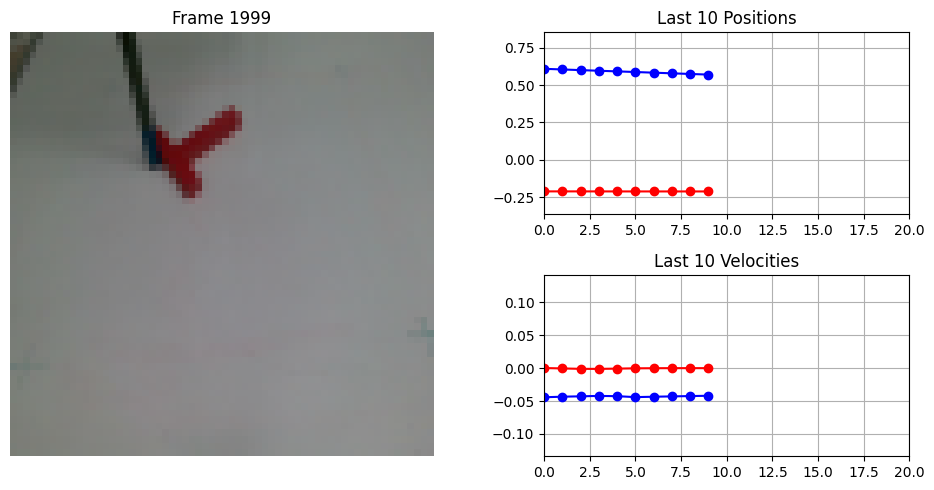

In [10]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# Example data (replace with your own)
# Suppose we have 50 frames
num_frames = len(images) - 1
num_frames = 2000

# images = [np.random.rand(100, 100) for _ in range(num_frames)]  # List of 2D arrays
# positions = np.linspace(0, 100, num_frames)  # Example scalar positions
# velocities = np.sin(np.linspace(0, 2*np.pi, num_frames)) * 10  # Example scalar velocities
positions_x = [p[0] for p in ps ]
positions_y = [p[1] for p in ps ]

min_pos = min(positions_x + positions_y)
max_pos = max(positions_x + positions_y)

velocities_x = [v[0] for v in vs ]
velocities_y = [v[1] for v in vs ]

min_vel = min(velocities_y + velocities_y)
max_vel = max(velocities_x + velocities_y)


# Parameters
history_length = 10  # number of last measurements to show

# Create figure and subplots
fig = plt.figure(figsize=(10, 5))
# GridSpec to organize:
# Left half: image
# Right half: two subplots stacked vertically for position and velocity
gs = fig.add_gridspec(2, 2, width_ratios=[1.5, 1], height_ratios=[1, 1])

ax_img = fig.add_subplot(gs[:, 0])           # Large subplot on the left for the image
ax_pos = fig.add_subplot(gs[0, 1])           # Top-right subplot for position
ax_vel = fig.add_subplot(gs[1, 1])           # Bottom-right subplot for velocity

# Initialize plots
img_plot = ax_img.imshow(images[0], cmap='gray', vmin=0, vmax=1)
ax_img.set_title("Frame 0")
ax_img.axis('off')

pos_line_x, = ax_pos.plot([], [], marker='o', linestyle='-', color='blue')
pos_line_y, = ax_pos.plot([], [], marker='o', linestyle='-', color='red')

ax_pos.set_title("Last 10 Positions")
ax_pos.set_xlim(0, history_length * 2)
ax_pos.set_ylim(min_pos, max_pos)
ax_pos.grid(True)

vel_line_x, = ax_vel.plot([], [], marker='o', linestyle='-', color='blue')
vel_line_y, = ax_vel.plot([], [], marker='o', linestyle='-', color='red')

ax_vel.set_title("Last 10 Velocities")
ax_vel.set_xlim(0, history_length * 2)
ax_vel.set_ylim( min_vel, max_vel)
ax_vel.grid(True)

def init():
    # Initialization function for FuncAnimation
    img_plot.set_data(images[0])
    pos_line_x.set_data([], [])
    pos_line_y.set_data([], [])
    vel_line_x.set_data([], [])
    vel_line_y.set_data([], [])
    return img_plot, pos_line_x, pos_line_y, vel_line_x , vel_line_y

def update(frame):
    # Update image
    img_plot.set_data(images[frame])
    ax_img.set_title(f"Frame {frame}")

    # Update position data (last 10 measurements)
    start_idx = max(0, frame - history_length + 1)
    pos_line_x.set_data(range(0 , frame+1 -start_idx ), positions_x[start_idx:frame+1])
    pos_line_y.set_data(range(0 , frame+1 -start_idx ), positions_y[start_idx:frame+1])

    
    
    # Update velocity data (last 10 measurements)
    vel_line_x.set_data(range(0 , frame+1 -start_idx ), velocities_x[start_idx:frame+1])
    vel_line_y.set_data(range(0 , frame+1 -start_idx ), velocities_y[start_idx:frame+1])

    
    return img_plot, pos_line_x ,  pos_line_y ,  vel_line_x ,  vel_line_y 

ani = animation.FuncAnimation(
    fig, update, frames=num_frames, init_func=init, blit=False, interval= 1 / dt
)

# Uncomment below to save to a video file (requires ffmpeg)
ani.save('output_video.mp4', fps=10, extra_args=['-vcodec', 'libx264'])

plt.tight_layout()
plt.show()


In [8]:
print([a-b for a,b in zip(positions_x,positions_y) ] )

[0.9913367522674094, 0.9913549341248857, 0.9913732307406511, 0.991379272828969, 0.9913668403173495, 0.9913525738426202, 0.991337310097723, 0.9913250004220493, 0.9913180598402727, 0.9913141354776867, 0.991312408720751, 0.9913112585200737, 0.991308981432778, 0.9913081049626293, 0.9913089805429013, 0.9913084585771571, 0.9913083727494746, 0.9913086887935422, 0.9913082185510542, 0.9913078210544599, 0.9913079926608755, 0.9913073083545207, 0.9913085770323438, 0.9913082659134739, 0.991309026210515, 0.9913090500470875, 0.9913099739927373, 0.9913083851776398, 0.9913096383178175, 0.9913093924617322, 0.9913099429517521, 0.9913101005679334, 0.9913098557438024, 0.9913108685991556, 0.9913124230710464, 0.991311176038962, 0.9913103101051963, 0.991311259316984, 0.9913118524443545, 0.9913122659453838, 0.9913129664623794, 0.9913127463392298, 0.9913134147521985, 0.991311940138105, 0.9913114705591064, 0.9913114127197867, 0.9913114758757178, 0.99131183633076, 0.991312997736884, 0.9913119904139647, 0.99131210